Given an image of a known object (sphere) with a known reflectance function,
this Colab illustrates how to perform optimization of spherical harmonics to
recover the lighting environment.

In [0]:
import math

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from colabtools import adhoc_import
with adhoc_import.Google3():
  from tensorflow_graphics.camera import orthographic
  from tensorflow_graphics.geometry import grid
  from tensorflow_graphics.geometry import vector
  from tensorflow_graphics.lighting import spherical_harmonics
  from tensorflow_graphics.util import math as tf_math

In [0]:
def compute_intersection_normal_sphere(image_width, image_height, sphere_radius,
                                       sphere_center, type):
  """Estimates sphere normal and depth for each pixel in the image."""
  # Generates a 2d grid storing pixel coordinates.
  pixel_grid_start = np.array((0.5, 0.5), dtype=type)
  pixel_grid_end = np.array((image_width - 0.5, image_height - 0.5), dtype=type)
  pixel_nb = np.array((image_width, image_height))
  pixels = grid.generate(pixel_grid_start, pixel_grid_end, pixel_nb)
  # Computes the ray direction of each pixel.
  pixel_ray = tf.math.l2_normalize(orthographic.ray(pixels), axis=-1)
  # Defines the position of pixels in world coordinates.
  zero_depth = np.zeros([image_width, image_height, 1])
  pixels_3d = orthographic.unproject(pixels, zero_depth)
  # Computes intersections with the sphere and surface normals for each ray.
  intersection_3d, surface_normal = vector.intersection_ray_sphere(
      sphere_center, sphere_radius, pixel_ray, pixels_3d)
  # Extracts data about the closest intersection.
  intersection_3d = intersection_3d[0, ...]
  surface_normal = surface_normal[0, ...]
  # Replaces NaNs with zeros.
  zeros = tf.zeros_like(pixels_3d)
  intersection_3d = tf.where(tf.is_nan(intersection_3d), zeros, intersection_3d)
  surface_normal = tf.where(tf.is_nan(surface_normal), zeros, surface_normal)
  return intersection_3d, surface_normal

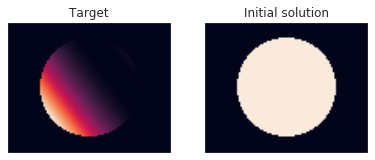

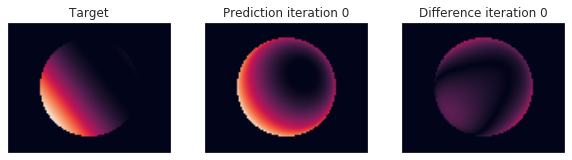

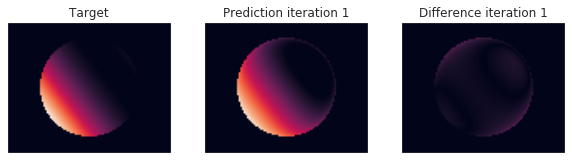

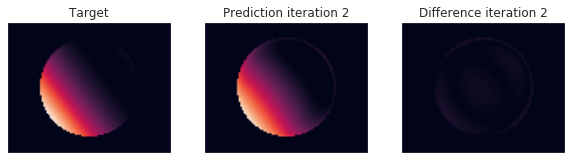

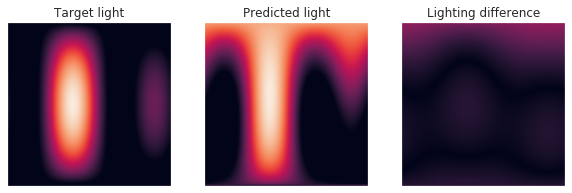

In [9]:
light_image_width = 100
light_image_height = 100
type = np.float64

############################################################################
# Builds the pixels grid and computes corresponding spherical coordinates. #
############################################################################
pixel_grid_start = np.array((0, 0), dtype=type)
pixel_grid_end = np.array((light_image_width - 1, light_image_height - 1),
                          dtype=type)
pixel_nb = np.array((light_image_width, light_image_height))
pixels = grid.generate(pixel_grid_start, pixel_grid_end, pixel_nb)
normalized_pixels = pixels / (light_image_width - 1, light_image_height - 1)
spherical_coordinates = tf_math.square_to_spherical_coordinates(
    normalized_pixels)
theta = spherical_coordinates[:, :, 1]
phi = spherical_coordinates[:, :, 2]

################################################################################################
# Builds the Spherical Harmonics and set coefficients for the light and reflectance functions. #
################################################################################################
max_band = 2
l, m = spherical_harmonics.generate_l_m_permutations(max_band)
l_broadcasted = tf.broadcast_to(
    l, [light_image_width, light_image_height] + l.shape.as_list())
m_broadcasted = tf.broadcast_to(
    m, [light_image_width, light_image_height] + l.shape.as_list())
theta = tf.expand_dims(theta, axis=-1)
theta_broadcasted = tf.broadcast_to(
    theta, [light_image_width, light_image_height] + l.shape.as_list())
phi = tf.expand_dims(phi, axis=-1)
phi_broadcasted = tf.broadcast_to(
    phi, [light_image_width, light_image_height] + l.shape.as_list())
sh_coefficients = spherical_harmonics.evaluate_spherical_harmonics(
    l_broadcasted, m_broadcasted, theta_broadcasted, phi_broadcasted)

# The lighting and BRDF coefficients come from the first Colab demo on Spherical
# Harmonics. TODO: add the link to that Colab once deployed on
# Tensorflow's repository.
light_coeffs = np.array((2.17136424e-01, -2.06274278e-01, 3.10378283e-17,
                         2.76236879e-01, -3.08694040e-01, -4.69862940e-17,
                         -1.85866463e-01, 7.05744675e-17, 9.14290771e-02))
brdf_coeffs = np.array((0.28494423, 0.33231551, 0.16889377))

# Reconstruction of the light function.
reconstructed_light_function = tf.squeeze(
    vector.dot(sh_coefficients, light_coeffs))

###################################
# Setup the image, and the sphere #
###################################
# Image dimensions
image_width = 100
image_height = 80

# Sphere center and radius
sphere_radius = np.array((30,), dtype=type)
sphere_center = np.array((image_width / 2.0, image_height / 2.0, 100.0),
                         dtype=type)

# Builds the pixels grid and compute corresponding spherical coordinates.
pixel_grid_start = np.array((0, 0), dtype=type)
pixel_grid_end = np.array((image_width - 1, image_height - 1), dtype=type)
pixel_nb = np.array((image_width, image_height))
pixels = grid.generate(pixel_grid_start, pixel_grid_end, pixel_nb)
normalized_pixels = pixels / (image_width - 1, image_height - 1)
spherical_coordinates = tf_math.square_to_spherical_coordinates(
    normalized_pixels)

################################################################################################
# For each pixel in the image, estimate the corresponding surface point and associated normal. #
################################################################################################
intersection_3d, surface_normal = compute_intersection_normal_sphere(
    image_width, image_height, sphere_radius, sphere_center, type)
surface_normals_spherical_coordinates = tf_math.cartesian_to_spherical_coordinates(
    surface_normal)

##########################################
# Estimates result using SH convolution. #
##########################################
target = spherical_harmonics.integration_product(
    light_coeffs,
    spherical_harmonics.rotate_zonal_harmonics(
        brdf_coeffs,
        tf.expand_dims(surface_normals_spherical_coordinates[:, :, 1], axis=-1),
        tf.expand_dims(surface_normals_spherical_coordinates[:, :, 2],
                       axis=-1)),
    keepdims=False)
# Sets pixels not belonging to the sphere to 0.
target = tf.where(
    tf.greater(intersection_3d[:, :, 2], 0.0), target, tf.zeros_like(target))

#########################################################################################
# Optimization of the lighting coefficients by minimization of the reconstruction error #
#########################################################################################
# Initial solution.
recovered_light_coeffs = tf.Variable(
    np.array((1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)))
# Op generating the prediction using the current solution.
prediction = spherical_harmonics.integration_product(
    recovered_light_coeffs,
    spherical_harmonics.rotate_zonal_harmonics(
        brdf_coeffs,
        tf.expand_dims(surface_normals_spherical_coordinates[:, :, 1], axis=-1),
        tf.expand_dims(surface_normals_spherical_coordinates[:, :, 2],
                       axis=-1)),
    keepdims=False)

# Sets pixels not belonging to the sphere to 0.
prediction = tf.where(
    tf.greater(intersection_3d[:, :, 2], 0.0), prediction,
    tf.zeros_like(target))

# Sets the optimization problem up.
with tf.name_scope("loss"):
  loss = tf.nn.l2_loss(prediction - target) / (image_width * image_height)

with tf.name_scope("optimizer"):
  optimizer = tf.contrib.opt.ScipyOptimizerInterface(
      loss, var_list=[recovered_light_coeffs], options={"maxiter": 1})

with tf.name_scope("initialize_variables"):
  init = tf.global_variables_initializer()

session = tf.Session()
session.run(init)

####################
# Initial solution #
####################
target_, prediction_ = session.run((target, prediction))
prediction_ = np.transpose(prediction_, (1, 0))
target_ = np.transpose(target_, (1, 0))
plt.figure(figsize=(10, 20))
ax = plt.subplot("131")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.grid(False)
ax.set_title("Target")
ax.imshow(target_, vmin=0.0)
ax = plt.subplot("132")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.grid(False)
ax.set_title("Initial solution")
ax.imshow(prediction_, vmin=0.0)

################
# Optimization #
################
nb_iterations = 3
for it in range(nb_iterations):
  optimizer.minimize(session)
  prediction_ = session.run(prediction)
  prediction_ = np.transpose(prediction_, (1, 0))
  # Displays the target and prediction.
  plt.figure(figsize=(10, 20))
  ax = plt.subplot("131")
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.grid(False)
  ax.set_title("Target")
  img = ax.imshow(target_, vmin=0.0)
  ax = plt.subplot("132")
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.grid(False)
  ax.set_title("Prediction iteration " + str(it))
  img = ax.imshow(prediction_, vmin=0.0)
  # Shows the difference between groundtruth and prediction.
  vmax = np.maximum(np.amax(prediction_), np.amax(target_))
  ax = plt.subplot("133")
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.grid(False)
  ax.set_title("Difference iteration " + str(it))
  img = ax.imshow(np.abs(prediction_ - target_), vmin=0.0, vmax=vmax)

# Reconstructs the groundtruth and predicted environment maps.
reconstructed_predicted_light = tf.squeeze(
    vector.dot(sh_coefficients, recovered_light_coeffs))
reconstructed_light_function_, reconstructed_predicted_light_ = session.run(
    [reconstructed_light_function, reconstructed_predicted_light])

# Displays the groundtruth and predicted environment maps.
plt.figure(figsize=(10, 20))
ax = plt.subplot("131")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.grid(False)
ax.set_title("Target light")
img = ax.imshow(reconstructed_light_function_, vmin=0.0)
ax = plt.subplot("132")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.grid(False)
ax.set_title("Predicted light")
img = ax.imshow(reconstructed_predicted_light_, vmin=0.0)
ax = plt.subplot("133")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.grid(False)
ax.set_title("Lighting difference")
img = ax.imshow(
    np.abs(reconstructed_predicted_light_ - reconstructed_light_function_),
    vmin=0.0,
    vmax=1.0)